In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re

from Analyse_Events_Functions import *

def find_quintile_with_max_value(intensities):
    
    # Number of elements in each quintile
    quintile_size = len(intensities) // 5
    
    # Calculate the indices that will split the array into quintiles
    quintile_indices = [i * quintile_size for i in range(1, 5)] + [len(intensities)]
    
    # Split the array into quintiles
    quintiles = np.array_split(intensities, 5)
    
    # Find the quintile that contains the maximum value
    max_value = np.max(intensities)
    for i, quintile in enumerate(quintiles):
        if max_value in quintile:
            return i
        
def interpolate_and_bin(normalized_time, normalized_rainfall):
    """
    Interpolate missing data points and bin the dimensionless profile into 12 segments.
    
    Parameters:
        normalized_time (np.array): Normalized time array.
        normalized_rainfall (np.array): Normalized cumulative rainfall array.
    
    Returns:
        np.array: Binned and interpolated rainfall profile.
    """
    # Define target points for 12 bins
    target_points = np.linspace(0, 1, 13)
    
    # Create interpolation function based on existing data points
    interpolation_func = interp1d(normalized_time, normalized_rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values


def check_for_nan(profiles_list):
    for i, profile in enumerate(profiles_list):
        if np.isnan(profile).any():
            print(f"NaN values found in profile {i}")
        else:
            pass

### Define EM to study

In [11]:
em = 'bc005'

# Create a set of dimensionless profiles
Read in all of the events, for all durations, for all gauges, for all ensemble members.  
Convert them to dimensionless profiles, with 12 values between 0 and 1.  
Each value is a dimensionless, cumulative rainfall value (cumulative rainfall at this timestep, normalised by the total event rainfall):
- 0 means no rainfall has occurred, and 
- 1 means the total event rainfall has been reached.  

If there are less than 12 values, then these are filled in with interpolation

In [21]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10), sharey=True)
nimrod_profiles = []
durations_for_nimrod_profiles = []
for gauge_num in range(0,10):
    # Create a list of all the event CSVs
    files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/") if f.endswith('.csv')]
    files = np.sort(files)

    # For each event
    for num, file in enumerate(files):
        test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/{file}")
        # find duration from file name
        pattern = re.compile(r'(\d+\.?\d*)hrs')
        match = pattern.search(file)
        duration = match.group(1)

        if len(test)==1:
            print(f"Only 1 value at gauge_num {gauge_num} for {file}")
        else:
            times = np.array(range(0,len(test)))
            normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
            interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
            nimrod_profiles.append(interpolated_rainfall) 
            heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)
            durations_for_nimrod_profiles.append(duration)
            
            if duration in ['0.5','1', '2', '3','6']:
                axs[0,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                          color = 'black')
            elif duration in ['12']:
                axs[1,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                          color = 'black')
            else:
                axs[2,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                          color = 'black')     
            

fig.supylabel('Dimensionless rainfall Rd', x= 0.09, fontsize=15);

In [158]:
import os
import re
import numpy as np
import pandas as pd

def process_file(gauge_num, file):
    # Read the CSV file
    test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/{file}")
    
    # Find duration from file name
    match = pattern.search(file)
    if match:
        duration = match.group(1)
    else:
        duration = None
    
    precipitation_sum = test['precipitation (mm)'].sum()

    if len(test) == 1:
        print(f"Only 1 value at gauge_num {gauge_num} for {file}")
        return None, None, None
    else:
        times = np.array(range(0, len(test)))
        normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
        interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
        heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)
        return interpolated_rainfall, duration, precipitation_sum

# Pre-compile the regex pattern
pattern = re.compile(r'(\d+\.?\d*)hrs')

# Initialize lists to store results
nimrod_profiles = []
durations_for_nimrod_profiles = []
volumes_for_nimrod_profiles = []

# Process each gauge
gauge_nums = next(os.walk(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/"))[1]
for gauge_num in gauge_nums:
    # Create a list of all the event CSVs
    files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/") if f.endswith('.csv')]
    files = np.sort(files)
    
    # Process each file
    for file in files:
        interpolated_rainfall, duration, precipitation_sum = process_file(gauge_num, file)
        if interpolated_rainfall is not None and duration is not None and precipitation_sum is not None:
            nimrod_profiles.append(interpolated_rainfall)
            durations_for_nimrod_profiles.append(duration)
            volumes_for_nimrod_profiles.append(precipitation_sum)


In [161]:
# import os
# import re
# import numpy as np
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor

# def process_file(gauge_num, file):
#     # Read the CSV file
#     test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/{file}")
#     volume = test['precipitation (mm)'].sum()
#     # Find duration from file name
#     match = pattern.search(file)
#     if match:
#         duration = match.group(1)
#     else:
#         duration = None
    
#     if len(test) == 1:
#         print(f"Only 1 value at gauge_num {gauge_num} for {file}")
#         return None, None
#     else:
#         times = np.array(range(0, len(test)))
#         normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
#         interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
#         heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)
#         return interpolated_rainfall, duration, volume

# def process_gauge(gauge_num):
#     # Create a list of all the event CSVs
#     files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/{gauge_num}/") if f.endswith('.csv')]
#     files = np.sort(files)
    
#     # Use ThreadPoolExecutor to parallelize file processing
#     with ThreadPoolExecutor() as executor:
#         results = executor.map(lambda file: process_file(gauge_num, file), files)
        
#     for interpolated_rainfall, duration, volume in results:
#         if interpolated_rainfall is not None and duration is not None:
#             nimrod_profiles.append(interpolated_rainfall)
#             durations_for_nimrod_profiles.append(duration)
#             volumes_for_nimrod_profiles.append(volume)    
        
    
# # Pre-compile the regex pattern
# pattern = re.compile(r'(\d+\.?\d*)hrs')

# # Initialize lists to store results
# nimrod_profiles = []
# durations_for_nimrod_profiles = []
# volumes_for_nimrod_profiles = []
            
# # Process each gauge in parallel using ThreadPoolExecutor
# with ThreadPoolExecutor() as executor:
#     executor.map(process_gauge, next(os.walk(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_unfiltered/"))[1])

In [162]:
# Calculate the cutoff for the top 10%
cutoff = np.percentile(volumes_for_nimrod_profiles, 90)

# Get indices of values in the top 10%
top_10_percent_indices = [i for i, x in enumerate(volumes_for_nimrod_profiles) if x >= cutoff]

# Extract corresponding values from the other list
top_10_percent_profiles = [nimrod_profiles[i] for i in top_10_percent_indices]
top_10_percent_durations = [durations_for_nimrod_profiles[i] for i in top_10_percent_indices]

In [93]:
# fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10), sharey=True)
# model_profiles = []
# durations_for_model_profiles = []
# lens_for_model_profiles = []

# # for gauge_num in next(os.walk(f"../../ProcessedData/IndependentEvents/UKCP18_30mins/bc005/"))[1]:
# for gauge_num in range(1,10):
#     print(gauge_num)
#     # Create a list of all the event CSVs
#     files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/Option2/") if f.endswith('.csv')]
#     files = np.sort(files)

#     # For each event
#     for num, file in enumerate(files):
#         test = pd.read_csv(f"../../ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/Option2/{file}")
#         lens_for_model_profiles.append((test['precipitation (mm)'].sum()))
        
#         # Find duration from file name
#         pattern = re.compile(r'(\d+\.?\d*)hrs')
#         match = pattern.search(file)
#         duration = match.group(1)

#         if len(test)==1:
#             print(f"Only 1 value at gauge_num {gauge_num} for {file}")
#         else:
#             times = np.array(range(0,len(test)))
#             normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
#             interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
#             model_profiles.append(interpolated_rainfall) 
#             heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)

#             if duration in ['0.5','1', '2', '3','6']:
#                 axs[0,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
#                                           color = 'black')
#             elif duration in ['12']:
#                 axs[1,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
#                                           color = 'black')
#             else:
#                 axs[2,heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
#                                           color = 'black')     
#             durations_for_model_profiles.append(duration)

# fig.supylabel('Dimensionless rainfall Rd', x= 0.09, fontsize=15);

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

## Classify and plot dimensionless profiles

### Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

5
10
15
20
25


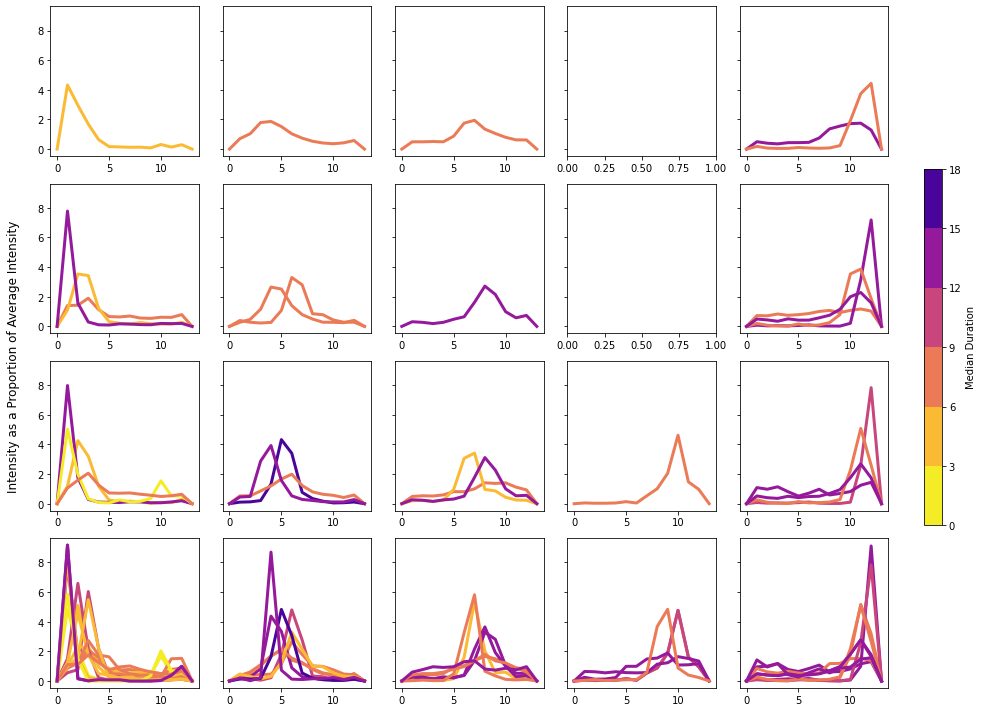

In [248]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import re
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles

durations_for_profiles_ls = [top_10_percent_durations]
linestyles = ['solid', 'dotted']

# Define hex color codes
hex_colors = ['#f3ec27', '#fbba33', '#eb7b56', '#c8467c', '#95199b', '#490499']

# Convert hex colors to RGBA format
rgba_colors = [mcolors.to_rgba(color) for color in hex_colors]
cmap = mcolors.ListedColormap(rgba_colors)
cmap

for number, profiles in enumerate([top_10_percent_profiles]):
    linestyle = linestyles[number]
    durations_for_profiles = durations_for_profiles_ls[number]
    for num_clusters in [5, 10,15, 20, 25]:
        print(num_clusters)
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df = pd.DataFrame({'cluster_num': labels, 'duration': durations_for_profiles})
        df['duration'] = pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].median()

        for num, centroid_cumulative in enumerate(centroids):
            median_duration = df[df["cluster_num"] == num]['duration'].median()
            color = cmap(norm(median_duration))

            # Find portion which is heaviest
            heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0, len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity
            normalized_intensity = np.insert(normalized_intensity, 0, 0, axis=0)
            normalized_intensity = np.insert(normalized_intensity, 13, 0, axis=0)
            time_hours = np.array(range(0, len(centroid_cumulative)+1))

            if num_clusters == 5:
                axs[0, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 10:
                axs[1, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)
            elif num_clusters == 15:
                axs[2, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3) 
            else:
                axs[3, quintile_with_max_value].plot(time_hours, normalized_intensity,
                                                     color=color, linestyle=linestyle, linewidth=3)

# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Median Duration')

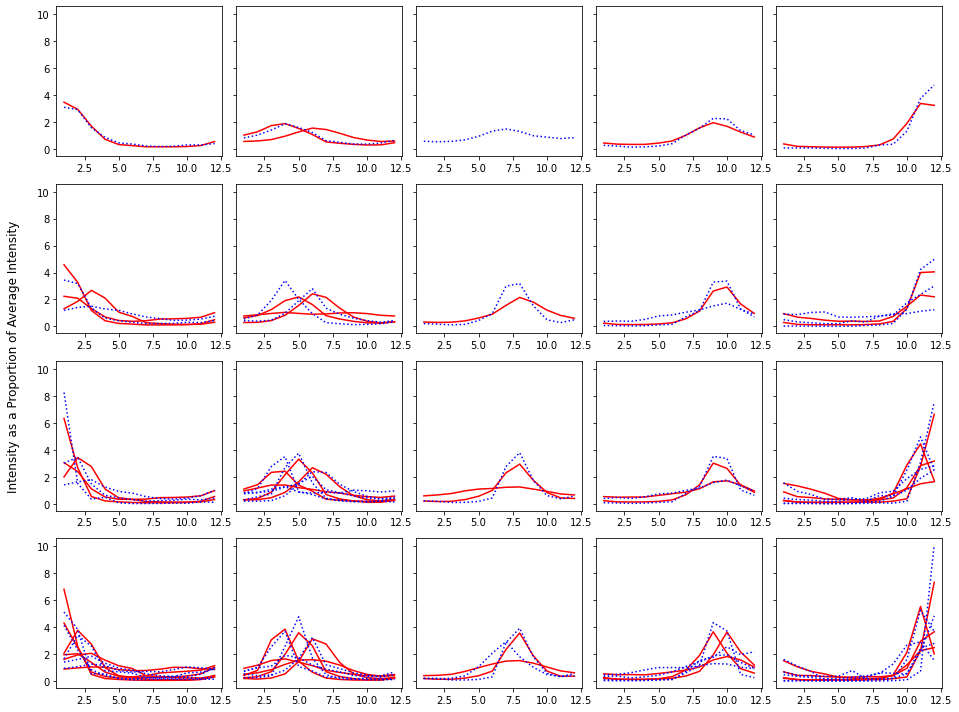

In [35]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles

durations_for_profiles_ls = [durations_for_model_profiles, durations_for_nimrod_profiles]
linestyles =['solid', 'dotted']
colours = ['red','blue']
for number, profiles in enumerate([model_profiles, nimrod_profiles]):
    color = colours[number]
    linestyle=linestyles[number]
    durations_for_profiles = durations_for_profiles_ls[number]
    for num_clusters in [5,10,15,20]:
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
        df['duration'] =  pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].mean()

        for num, centroid_cumulative in enumerate(centroids):

            # Find portion which is heaviest
            heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity


            if num_clusters ==5 :
                axs[0, quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==10:
                axs[1,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==15:
                axs[2,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle) 
            else:
                axs[3,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)  

    # Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

### Compare to the RVH profiles

In [40]:
# Read in profiles
rvh_profiles = pd.read_csv("../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'irain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']

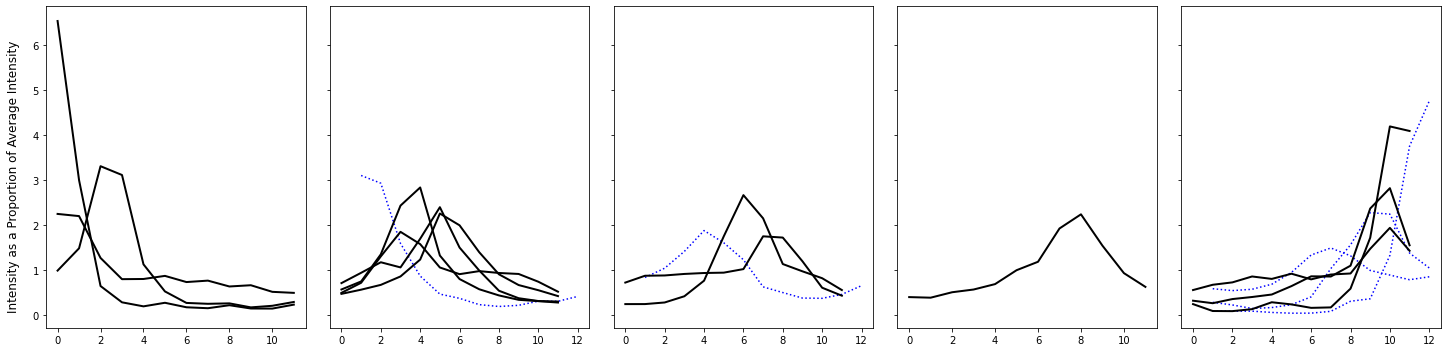

In [42]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles
num_clusters=5

# Create and fit the model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(profiles)

# Get cluster labels for each profile
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
df['duration'] =  pd.to_numeric(df['duration'])
df.groupby('cluster_num')['duration'].mean()

for num, centroid_cumulative in enumerate(centroids):

    # Find portion which is heaviest
    heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

    # Convert to intensity
    time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

    # Convert cumulative to intensity (mm/hour)
    intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

    # Calculate average intensity
    average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

    # Normalize intensity by average intensity
    normalized_intensity = intensity / average_intensity

    # plot
    axs[heaviest_segment].plot(time_hours[1:], normalized_intensity,
                              color='blue', linestyle='dotted') 

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
    axs[quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='black')   
    
    
# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

In [47]:
profiles[1]

array([0.01177138, 0.10608608, 0.22691677, 0.32273467, 0.40188475,
       0.52188647, 0.62893637, 0.66297388, 0.66393549, 0.66393549,
       0.66656609, 0.91473765, 1.        ])